In [1]:
%load_ext autoreload
%autoreload 2

### General imports 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

### Custom functions
import sys
sys.path.append('../python')
from functions import *
from models import *

### ML-related
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-10 16:46:02.835962: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-10 16:46:02.856756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-06-10 16:46:02.857162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-10 16:46:02.859268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-10 16:46:02.861437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-10 16:46:02.861905: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-0

### Load a patch from a trained model

In [2]:
test = pd.read_hdf("./test/patches/patch4/df_test.h5")
### for tail only: 
# test.α = test.α + 212.7 
# test.δ = test.δ + 55.2

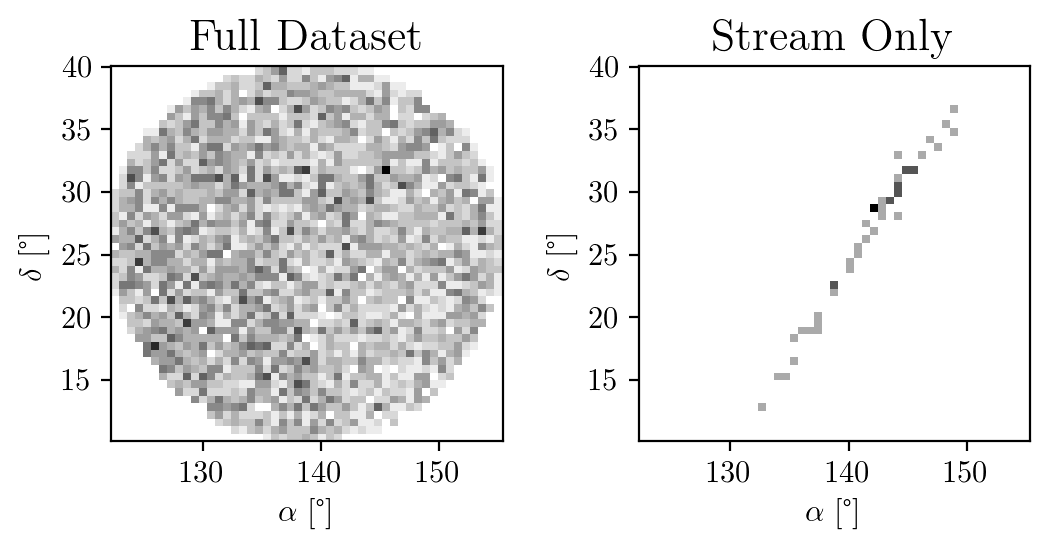

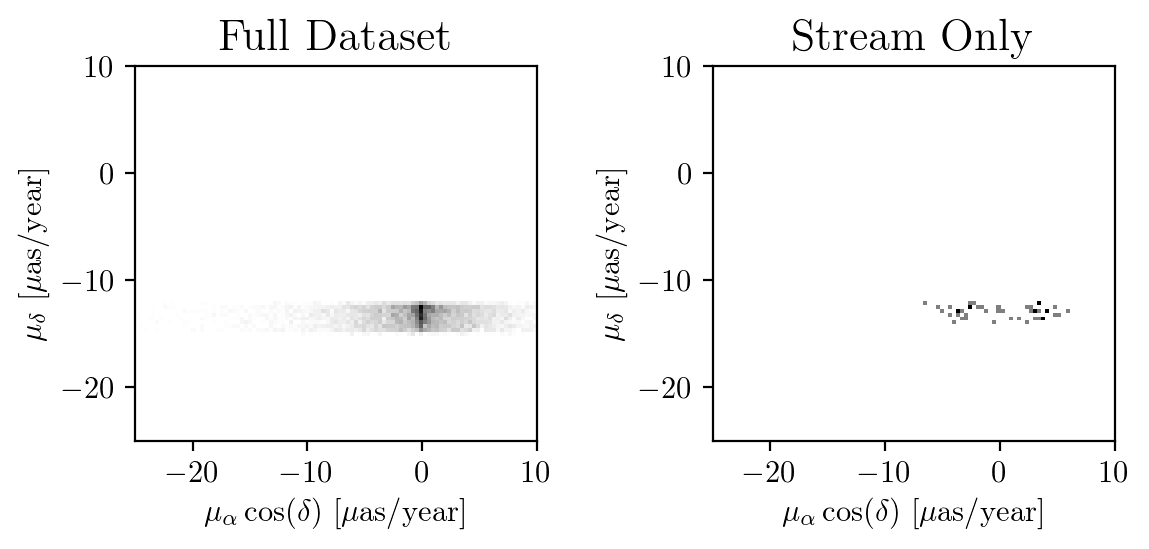

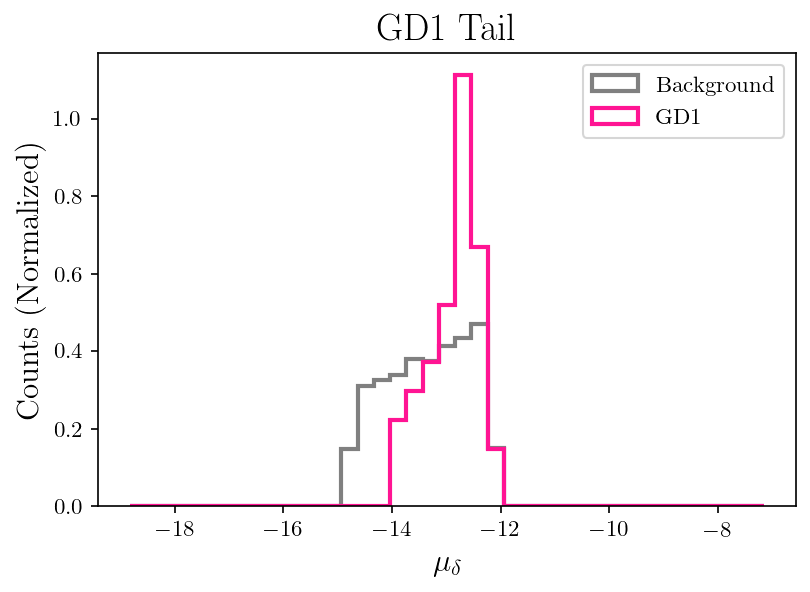

In [3]:
visualize_stream(test)

Top 50 stars: Purity = 50.0% 


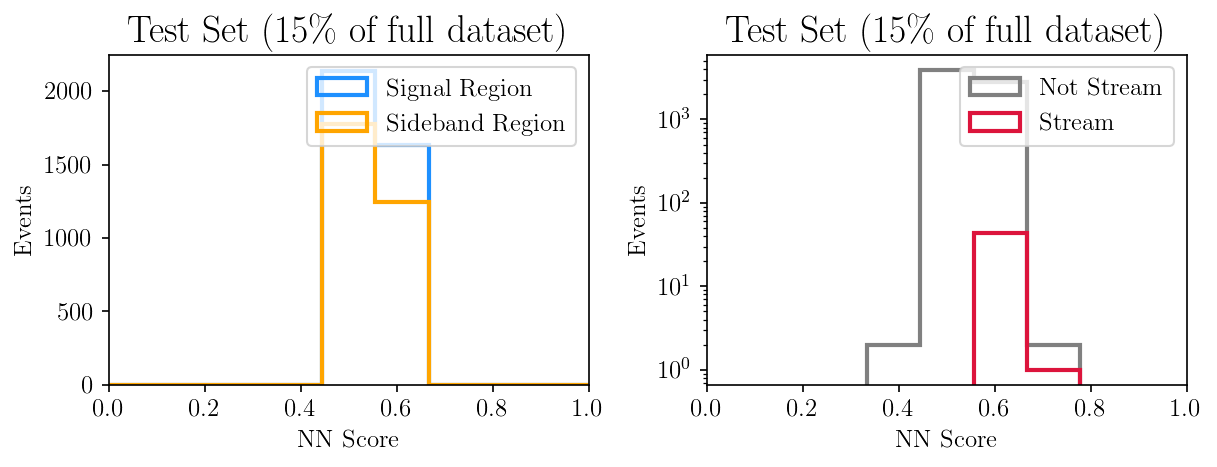

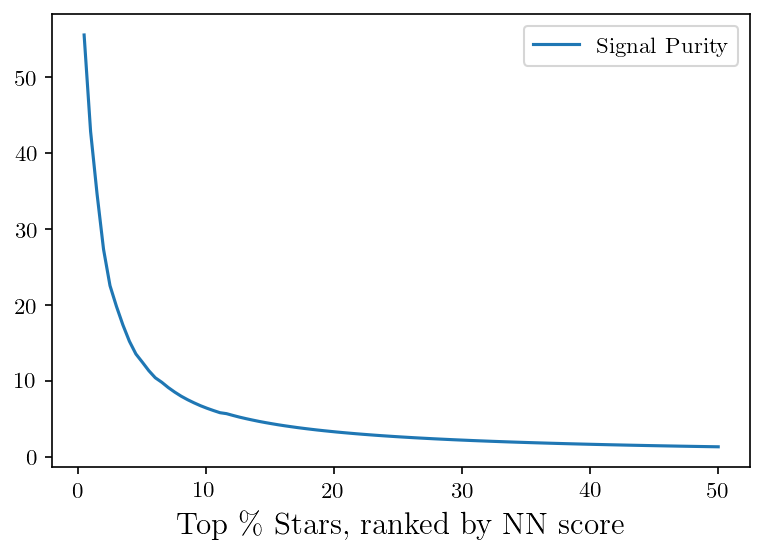

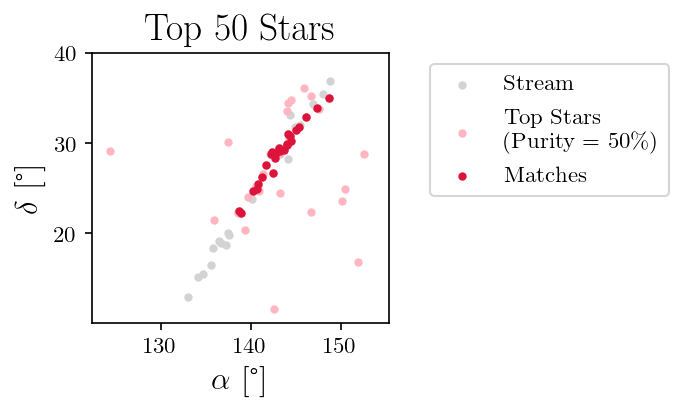

In [4]:
plot_results(test)

### Now let's investigate the stars that look plausibly stream-like but are not labeled as part of the stream

In [27]:
n_top_stars = 50
top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars] # pick the top ranked stars 

# sort by labeled and unlabeled 
labeled = top_stars[top_stars.stream]
unlabeled = top_stars[top_stars.stream == False]

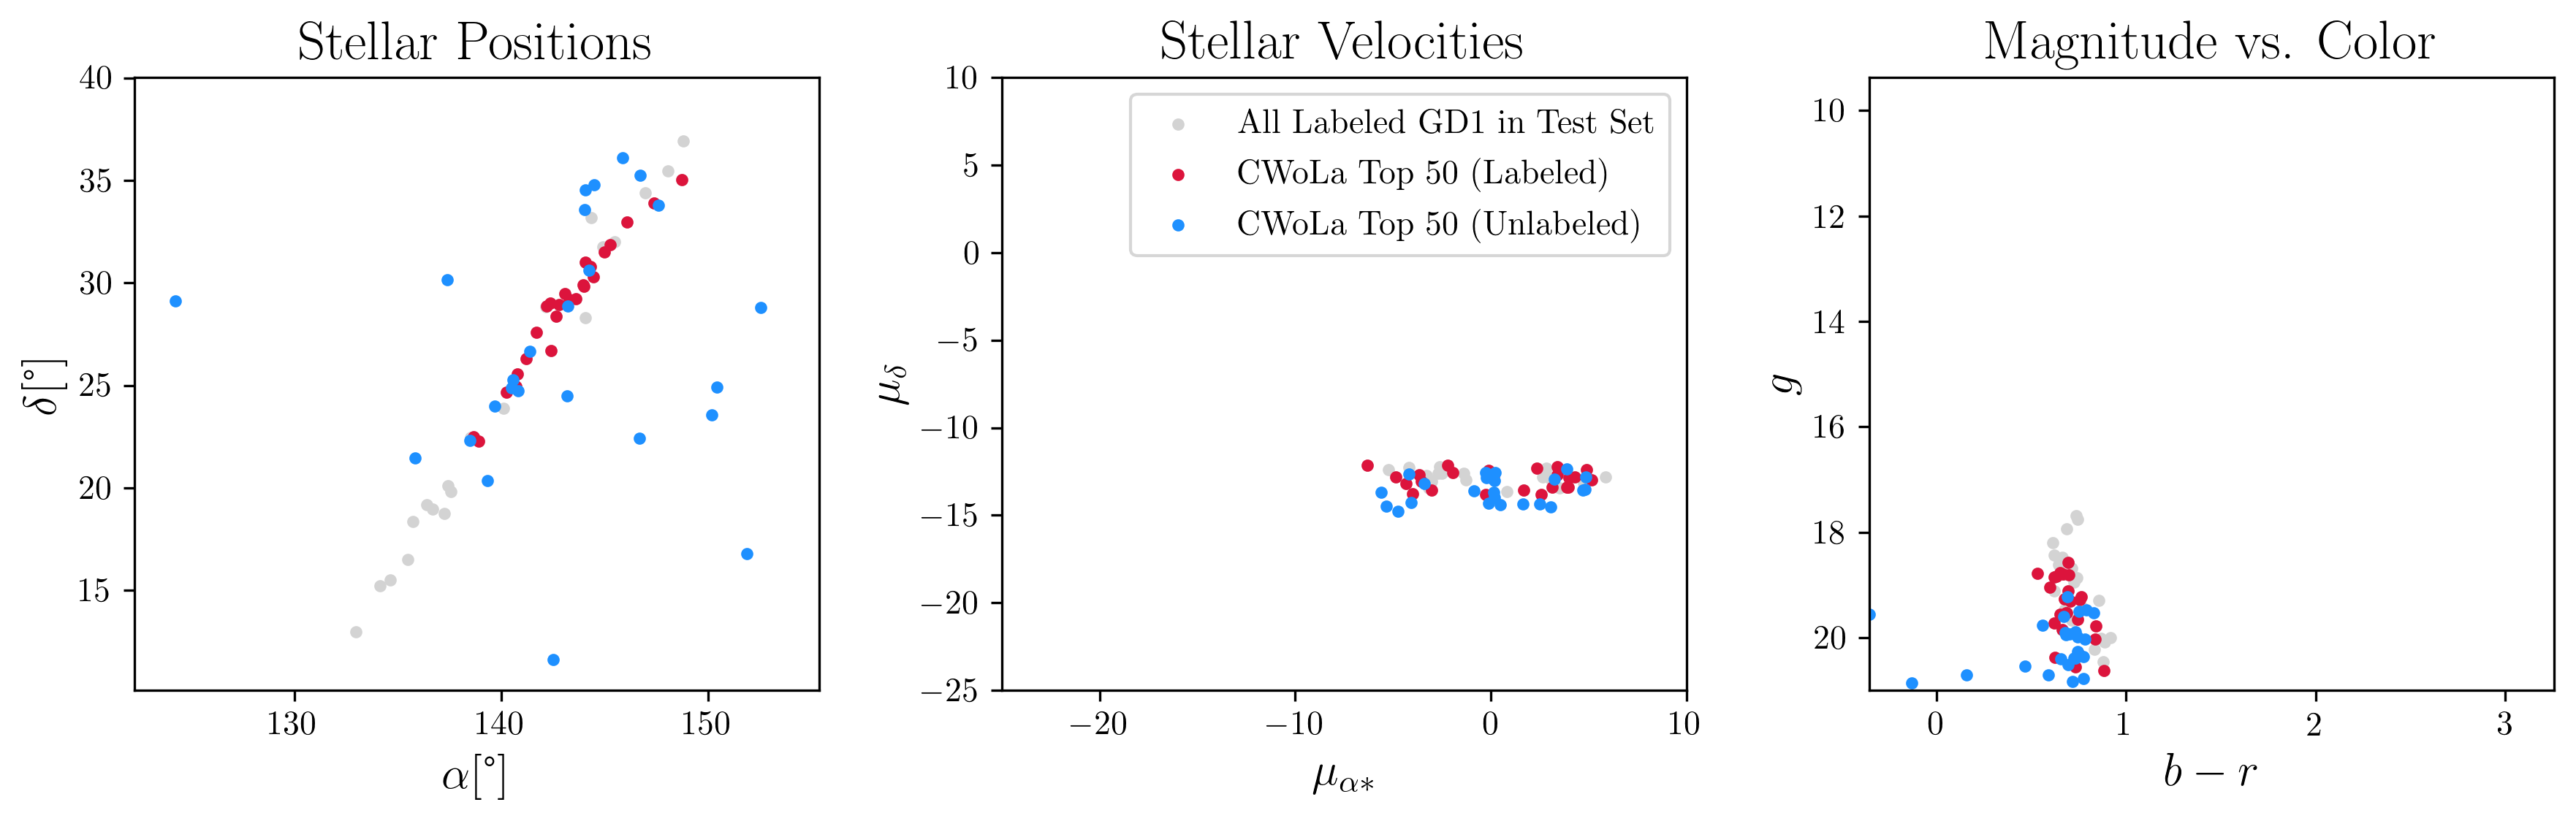

In [52]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α*np.cos(test[test.stream].δ), test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α*np.cos(labeled.δ), labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α*np.cos(unlabeled.δ), unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlim(-25,10)
ax.set_ylim(-25,10)
ax.legend()
# ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.set_xlabel(r"$\mu_{\alpha *}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_ylim(ax.get_ylim()[::-1]) # reverse y axis to match Via Machinae plot
ax.set_xlabel(r"$b-r$")
ax.set_ylabel(r"$g$");
ax.set_xlim(test.color.min(),test.color.max())
ax.set_ylim(test.mag.max(),test.mag.min());
plt.savefig("../plots/mislabeled_triptych.png")
plt.savefig("../plots/mislabeled_triptych.pdf")

What are the distances along the 5 dimensions to the true stream stars in the test set? 

In [53]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]

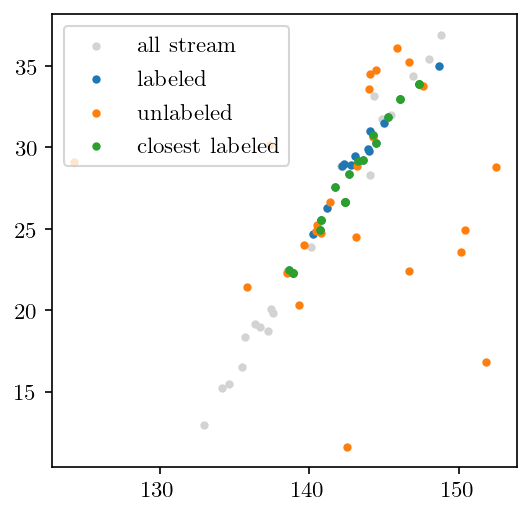

In [54]:
fig = plt.figure(figsize=(4,4), dpi=150)
plt.scatter(test[test.stream].α, test[test.stream].δ, color="lightgray", marker='.', label="all stream")
plt.scatter(labeled.α, labeled.δ, label="labeled", marker='.')
plt.scatter(unlabeled.α, unlabeled.δ, label="unlabeled", marker='.')
plt.scatter(closest_labeled.α, closest_labeled.δ, label="closest labeled", marker='.')
plt.legend()

In [55]:
closest_dists = distance_matrix(closest_labeled[cols].to_numpy(), unlabeled[cols].to_numpy())

In [91]:
np.histogram(distances, bins=5)

(array([14,  4,  3,  2,  2]),
 array([ 0.24282308,  3.85090784,  7.4589926 , 11.06707736, 14.67516212,
        18.28324688]))

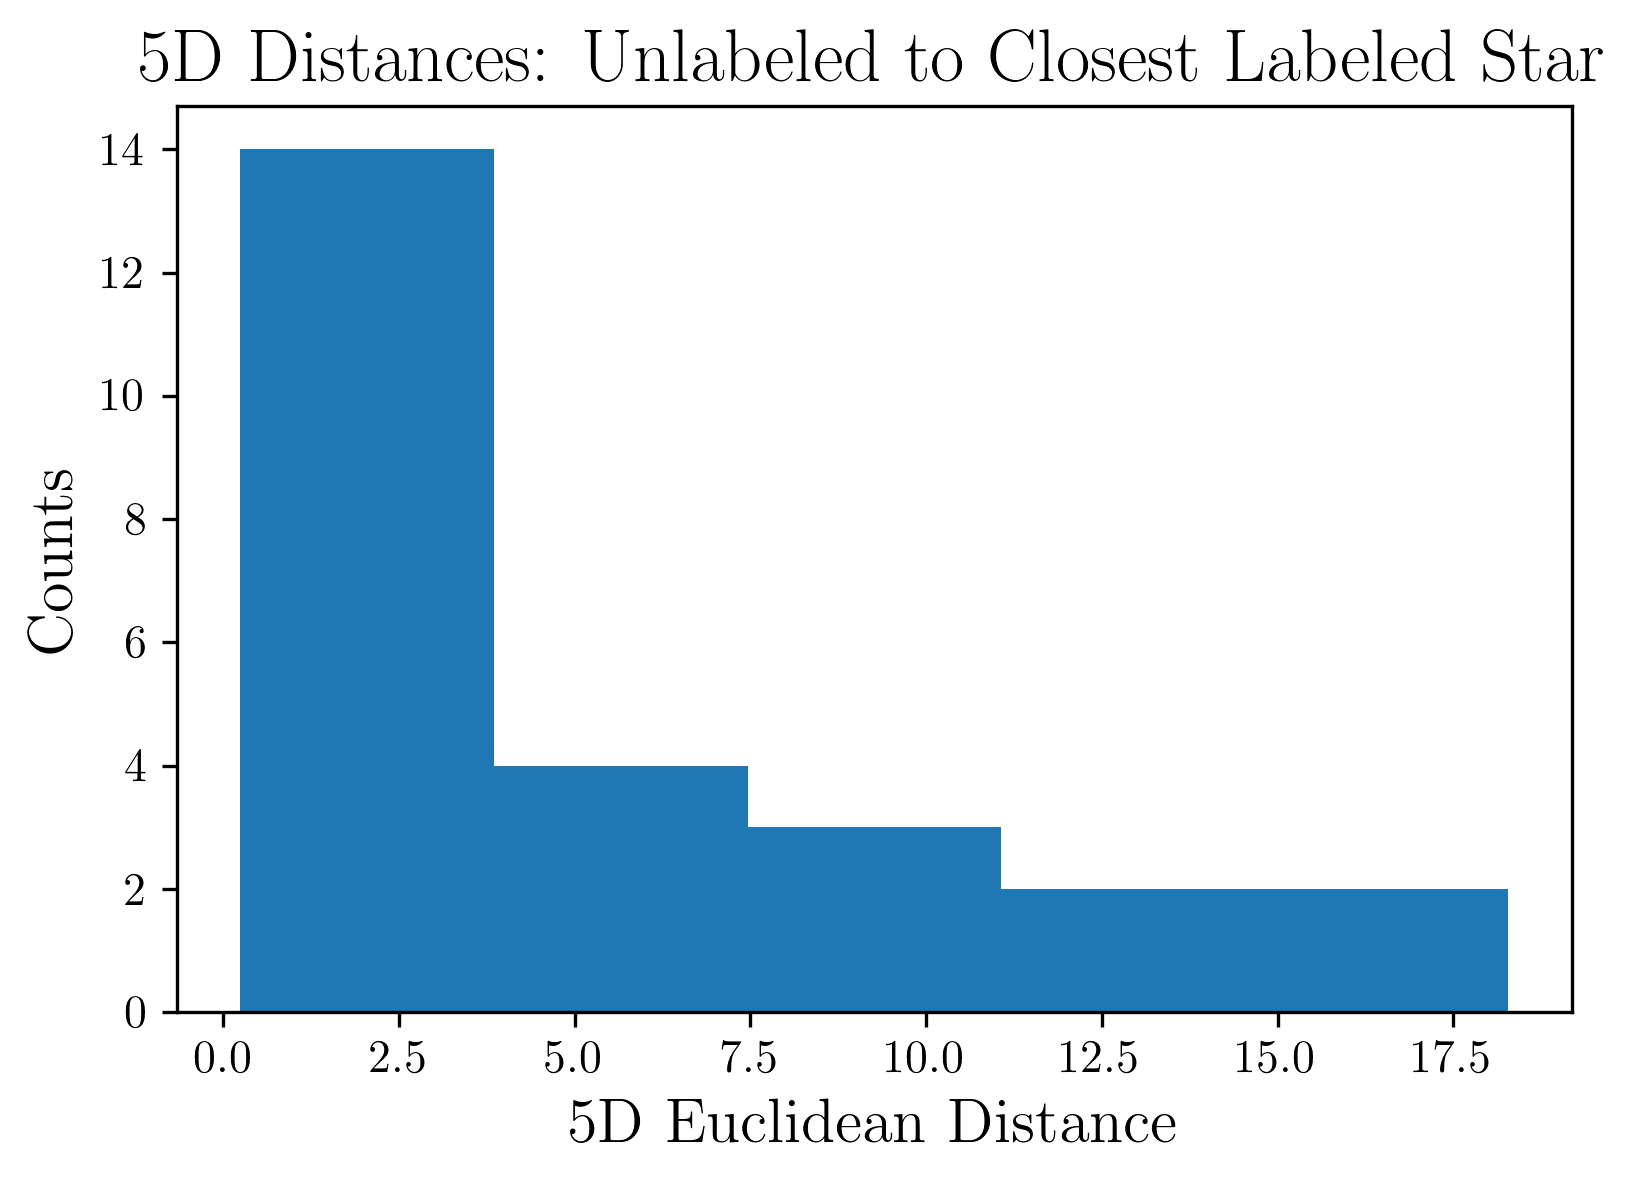

In [97]:
plt.figure(dpi=300)
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
plt.hist(distances, bins=5)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance")
plt.savefig("../plots/5d_distance.pdf")

In [94]:
unlabeled['5d_distance'] = distances
promising = unlabeled[(unlabeled['5d_distance'] < 2)] # select a maximum 5D distance for promising stars
print("Adding {} promising stars would increase the purity from {:.0f}% to {:.0f}%.".format(len(promising), 
                                                                                            100*len(labeled)/(len(labeled)+len(unlabeled)),
                                                                                            100*(len(labeled)+len(promising))/(len(labeled)+len(unlabeled))))

Adding 8 promising stars would increase the purity from 50% to 66%.


/tmp/ipykernel_6603/582534723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled['5d_distance'] = distances


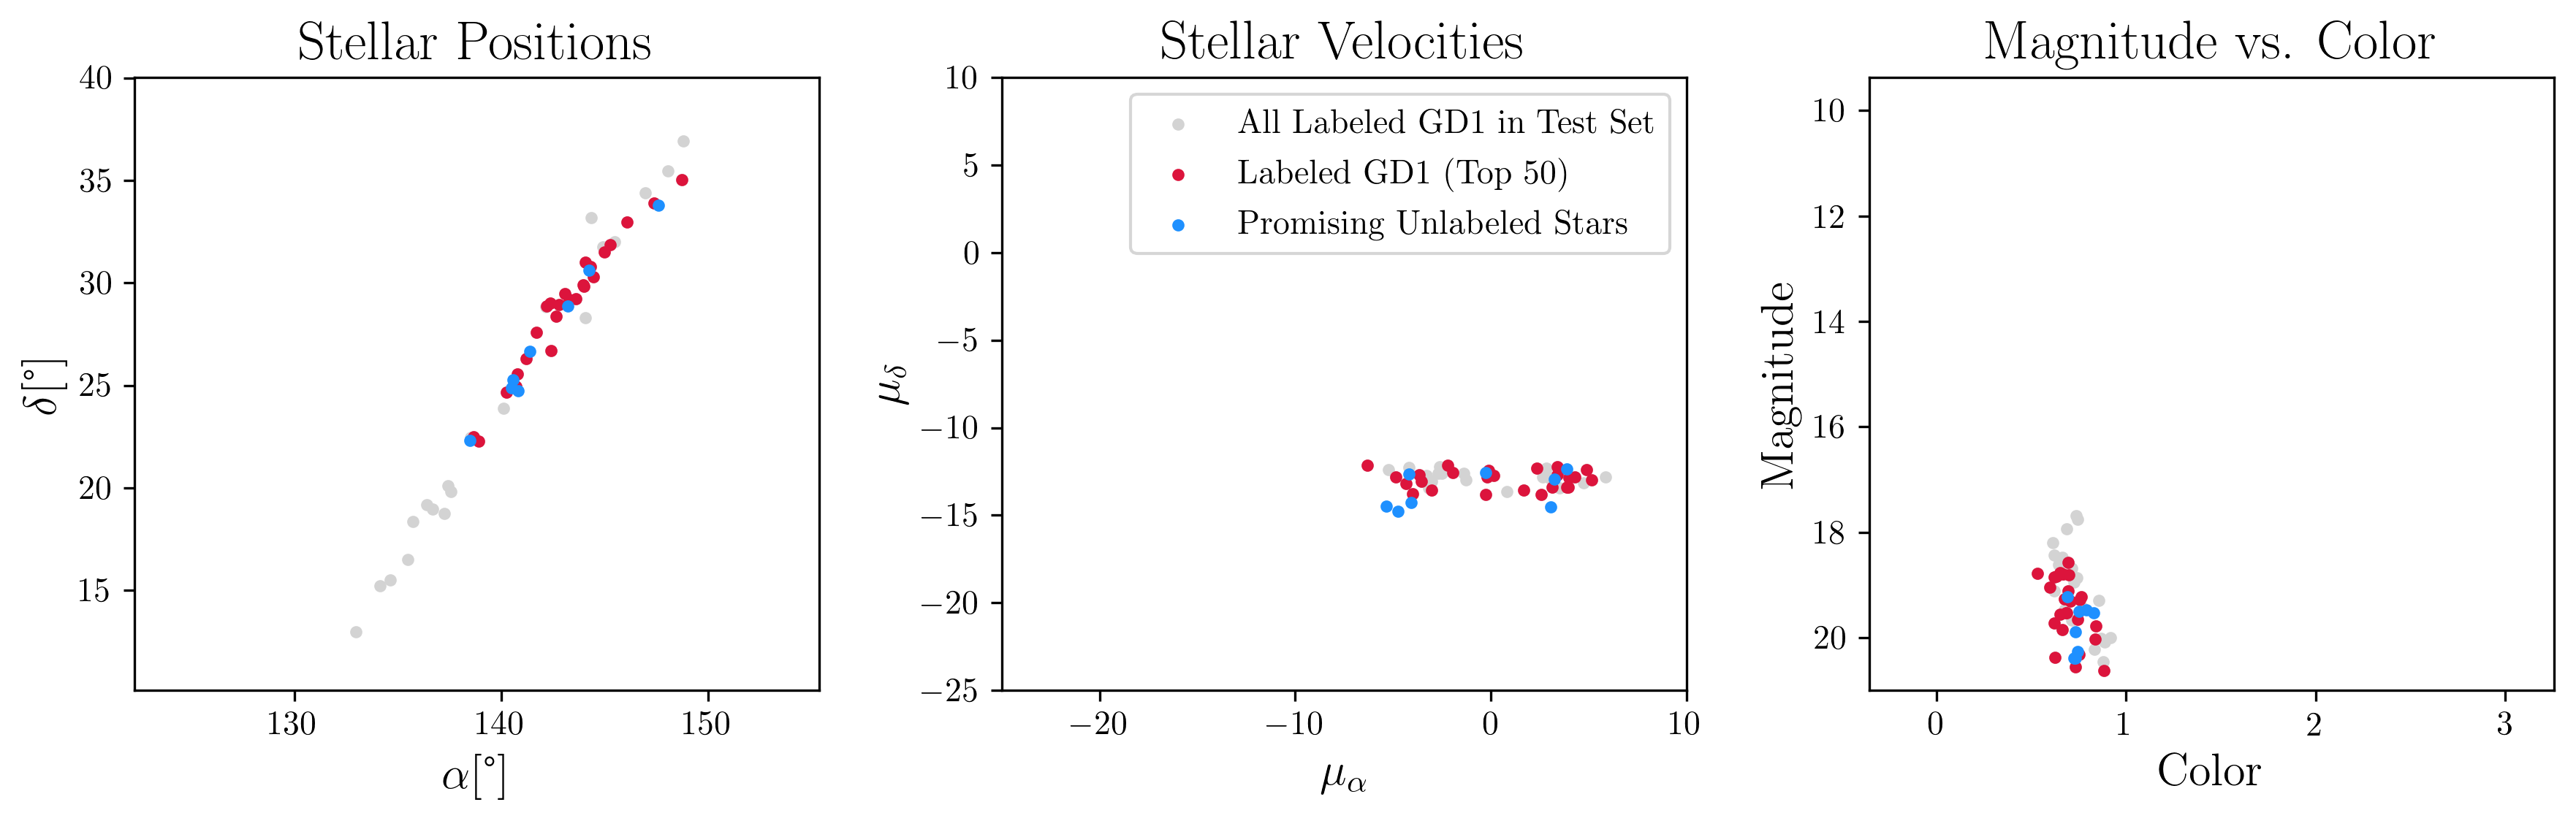

In [95]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True, dpi=300)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(test.α.min(),test.α.max())
ax.set_ylim(test.δ.min(),test.δ.max())
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α*np.cos(test[test.stream].δ), test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α*np.cos(labeled.δ), labeled.μ_δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.μ_α*np.cos(promising.δ), promising.μ_δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-25,10)
ax.set_ylim(-25,10)
ax.legend()
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(test.color.min(),test.color.max())
ax.set_ylim(test.mag.max(),test.mag.min());
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
plt.savefig("../plots/promising_triptych.png")
plt.savefig("../plots/promising_triptych.pdf")

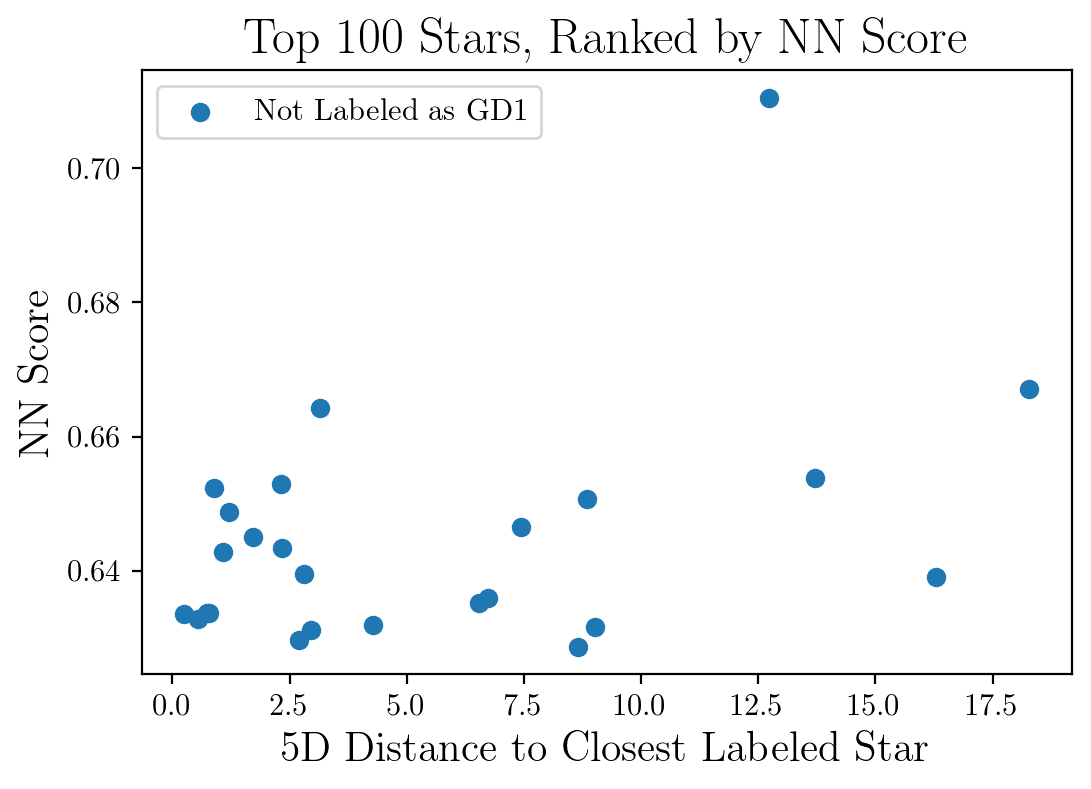

In [96]:
plt.figure(dpi=200)
# plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Labeled as GD1")
plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Not Labeled as GD1")
plt.xlabel("5D Distance to Closest Labeled Star")
plt.ylabel("NN Score")
plt.title("Top 100 Stars, Ranked by NN Score")
plt.legend()